<p align="center">
 <img src="http://www.di.uoa.gr/themes/corporate_lite/logo_en.png" title="Department of Informatics and Telecommunications - University of Athens"/> </p>

<br>

---

<h3 align="center" > 
  Bachelor Thesis
</h3>

<h1 align="center" > 
  Entity Resolution in Dissimilarity Spaces <br>
  Implementation notebook
</h1>

---

<h3 align="center"> 
 <b>Konstantinos Nikoletos</b>
</h3>

<h4 align="center"> 
 <b>Supervisors:<br> Dr. Alex Delis</b>,  Professor NKUA <br> <b> Dr. Vassilis Verikios</b>, Professor Hellenic Open University

</h4>
<br>
<h4 align="center"> 
Athens
</h4>
<h4 align="center"> 
January 2021 - Ongoing
</h4>


---

# __Implementation__

## __0.0 Install components__

In [ ]:
!pip install editdistance

In [ ]:
!pip install pandas
import pandas as pd
print(pd.__version__)

In [ ]:
!pip install pandas_read_xml

In [ ]:
!pip install requests

## __0.1 Import libraries__

In [79]:
import pandas as pd
import numpy as np
import collections
import editdistance
import string
import sklearn
import pandas_read_xml as pdx
import time
import warnings
import sys
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import math

from tqdm.notebook import tqdm as tqdm
from scipy.spatial.distance import directed_hausdorff,hamming
from scipy.stats._stats import _kendall_dis
from scipy.stats import spearmanr,kendalltau,pearsonr,kruskal,mannwhitneyu
from sklearn.metrics.pairwise import cosine_similarity
from nltk.metrics.distance import jaro_similarity,jaro_winkler_similarity,jaccard_distance
from sklearn.metrics import jaccard_score,accuracy_score,auc,f1_score,recall_score,precision_score,classification_report
from scipy.sparse import csr_matrix
from scipy import sparse
from scipy import stats 
from scipy.spatial.distance import euclidean,hamming
from matplotlib.patches import Rectangle
from sklearn.metrics import ndcg_score

plt.style.use('seaborn-whitegrid') # plot style

## __Final model__









In [80]:
class RankedWTAHash:

  def __init__(self, max_numberOf_clusters, max_editDistance, windowSize, number_of_permutations=1, min_numOfNodes = 2,jaccard_withchars =True,distanceMetricEmbedding = 'l_inf', metric = 'kendal', similarityVectors='ranked', distanceMetric = 'edit', ngramms=3, similarityThreshold=None, maxOnly=None ):
    '''
      Constructor
    '''
    self.max_numberOf_clusters = max_numberOf_clusters
    self.pairDictionary = dict()
    self.max_editDistance = max_editDistance
    self.windowSize = windowSize
    self.S_set = None 
    self.S_index = None 
    self.similarityThreshold = similarityThreshold
    self.maxOnly = maxOnly
    self.metric = metric
    self.min_numOfNodes = min_numOfNodes
    self.similarityVectors = similarityVectors
    self.number_of_permutations = number_of_permutations
    self.distanceMetric = distanceMetric
    self.distanceMetricEmbedding = distanceMetricEmbedding
    self.ngramms = ngramms
    self.jaccard_withchars =  jaccard_withchars
  
  def fit(self, X):
    """
      Fit the classifier from the training dataset.
      Parameters
      ----------
      X : Training data.
      Returns
      -------
      self : The fitted classifier.
    """
    print("\n#####################################################################\n#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #\n#####################################################################\n")

    if isinstance(X, list):
      input_strings = X
    else:
      input_strings = list(X)

    # print(input_strings)
    self.initialS_set = np.array(input_strings,dtype=object)
    self.S_set = np.array(input_strings,dtype=object)
    if self.distanceMetric == 'jaccard' and self.jaccard_withchars == False:    
      for i in range(0,len(input_strings)):
        self.S_set[i] = set(nltk.ngrams(nltk.word_tokenize(data[i]), n=self.ngramms))
    elif self.distanceMetric == 'jaccard' and self.jaccard_withchars == True:    
      for i in range(0,len(input_strings)):
        self.S_set[i] = set(nltk.ngrams(data[i], n=self.ngramms))
    # print(self.S_set)

    self.S_index = np.arange(0,len(input_strings),1)

    # print("\n\nString positions are:")
    # print(self.S_index)
    # print("\n")

    print("###########################################################\n# > 1. Prototype selection phase                          #\n###########################################################\n")
    print("\n-> Finding prototypes and representatives of each cluster:")
    prototypes_time = time.time()
    self.prototypeArray,self.selected_numOfPrototypes = self.Clustering_Prototypes(self.S_index,self.max_numberOf_clusters, self.max_editDistance, self.pairDictionary)
    print("\n- Prototypes selected")
    self.embeddingDim = self.prototypeArray.size
    print(self.prototypeArray)
    for pr in self.prototypeArray:
        print(pr," -> ",self.initialS_set[pr])
    print("\n- Final number of prototypes: ",self.selected_numOfPrototypes )
    prototypes_time = time.time() - prototypes_time
    print("\n# Finished in %.6s secs" % (prototypes_time))
    print("\n")

    print("###########################################################\n# > 2. Embeddings based on the Vantage objects            #\n###########################################################\n")
    print("\n-> Creating Embeddings:")
    embeddings_time = time.time()
    self.Embeddings = self.CreateVantageEmbeddings(self.S_index,self.prototypeArray, self.pairDictionary)
    print("- Embeddings created")
    print(self.Embeddings)
    embeddings_time = time.time() - embeddings_time
    print("\n# Finished in %.6s secs" % (embeddings_time))
    print("\n")


    print("###########################################################\n# > 3. WTA Hashing                                        #\n###########################################################\n")
    print("\n-> Creating WTA Buckets:")
    wta_time = time.time()
    self.HashedClusters,self.buckets,self.rankedVectors = self.WTA(self.Embeddings,self.windowSize,self.embeddingDim, self.number_of_permutations)
    print("- WTA buckets: ")
    for key in self.buckets.keys():
      print(key," -> ",self.buckets[key])
    print("\n- WTA number of buckets: ", len(self.buckets.keys()))
    print("\n- WTA RankedVectors after permutation:")
    print(self.rankedVectors)
    wta_time = time.time() - wta_time
    print("\n# Finished in %.6s secs" % (wta_time))
    print("\n")

    print("###########################################################\n# > 4. Similarity checking                                #\n###########################################################\n")
    print("\n-> Similarity checking:")
    similarity_time = time.time()

    if self.similarityVectors == 'ranked':
      self.mapping,self.mapping_matrix = self.SimilarityEvaluation(self.buckets,self.rankedVectors,self.similarityThreshold,maxOnly=self.maxOnly, metric=self.metric)
    elif self.similarityVectors == 'initial':
      self.mapping,self.mapping_matrix = self.SimilarityEvaluation(self.buckets,self.Embeddings,self.similarityThreshold,maxOnly=self.maxOnly, metric=self.metric)      
    else:
      warnings.warn("similarityVectors: Available options are ranked,initial")
#     print("- Similarity matrix (all values compared):")
#     print(self.similarityProb_matrix)
    print("- Similarity mapping in a matrix")
    print(self.mapping_matrix)
    similarity_time = time.time() - similarity_time
    print("\n# Finished in %.6s secs" % (similarity_time))
    print("\n#####################################################################\n#                    .~ End of training ~.                          #\n#####################################################################\n")

    return self

  def EditDistance(self, str1,str2,verbose=False):
      if verbose:
        if str1 == None:
            print("1")
        elif str2 == None:
            print("2")
        print("-> "+str(str1))
        print("--> "+str(str2))
        print(str(editdistance.eval(self.S_set[str1],self.S_set[str2])))
      
      
      # NOTE: Duplicates inside the dictionary     

      if ((str1,str2) or (str2,str1))  in self.pairDictionary.keys():
        return self.pairDictionary[(str1,str2)]
      else:
        # if verbose:
        # print("++++++++++")
        # print(str1,str2)
        # print(self.S_set[str1],self.S_set[str2])
        # print("++++++++++")
        if self.distanceMetric == 'edit':
            distance = editdistance.eval(self.S_set[str1],self.S_set[str2])
        elif self.distanceMetric == 'jaccard':
            distance = 1-jaccard_distance(self.S_set[str1],self.S_set[str2])
#             # 1-jaccard because we want DISSIMILARITY and jaccard counts SIMILARITY  
            print("-> "+str(self.initialS_set[str1]))
            print("--> "+str(self.initialS_set[str2]))
            print(distance)
        else:
            warnings.warn("Available metrics for space creation: edit, jaccard ")
        self.pairDictionary[(str2,str1)] = self.pairDictionary[(str1,str2)] = distance
        return distance

  #####################################################################
  # 1. Prototype selection algorithm                                  #
  #####################################################################

  '''
  Clustering_Prototypes(S,k,d,r,C) 
  The String Clustering and Prototype Selection Algorithm
  is the main clustering method, that takes as input the intial strings S, 
  the max number of clusters to be generated in k,
  the maximum allowable distance of a string to join a cluster in var d
  and returns the prototype for each cluster in array Prototype
  '''
  def Clustering_Prototypes(self,S,k,d,pairDictionary,verbose=False):
      
      # ----------------- Initialization phase ----------------- #
      i = 0
      j = 0
      C = np.empty([S.size], dtype=int)
      r = np.empty([2,k],dtype=object)

      Clusters = [ [] for l in range(0,k)]

      for i in tqdm(range(0,S.size,1)):     # String-clustering phase, for all strings
          while j < k :       # iteration through clusters, for all clusters
              if r[0][j] == None:      # case empty first representative for cluster j
                  r[0][j] = S[i]   # init cluster representative with string i
                  C[i] = j         # store in C that i-string belongs to cluster j
                  Clusters[j].append(S[i])
                  break
              elif r[1][j] == None and (self.EditDistance(S[i],r[0][j]) <= d):  # case empty second representative 
                  r[1][j] = S[i]                                             # and ED of representative 1  smaller than i-th string 
                  C[i] = j
                  Clusters[j].append(S[i])
                  break
              elif (r[0][j] != None and r[1][j] != None) and (self.EditDistance(S[i],r[0][j]) + self.EditDistance(S[i],r[1][j])) <= d:
                  C[i] = j
                  Clusters[j].append(S[i])
                  break
              else:
                  j += 1
          i += 1

      # ----------------- Prototype selection phase ----------------- #
          
      Projections = np.empty([k],dtype=object)
      Prototypes = np.empty([k],dtype=int)
      sortedProjections = np.empty([k],dtype=object)

      Projections = []
      Prototypes = []
      sortedProjections = []

      if verbose:
          print("- - - - - - - - -")
          print("Cluster array:")
          print(C)
          print("- - - - - - - - -")
          print("Represantatives array:")
          print(r)
          print("- - - - - - - - -")  
          print("Clusters:")
          print(Clusters)
          print("- - - - - - - - -")  

      new_numofClusters = k

      # print("\n\n\n****** Prototype selection phase *********") 
      prototype_index = 0
      for j in range(0,k,1):
          
          # IF small cluster
          # print("Len ",len(Clusters[j]))
          if len(Clusters[j]) < self.min_numOfNodes or r[1][j] == None or r[0][j]==None:
            new_numofClusters-=1
            continue

          Projections.append(self.Approximated_Projection_Distances_ofCluster(r[1][j], r[0][j], j, Clusters[j],pairDictionary))         
          # print(Projections[prototype_index])
          sortedProjections.append({new_numofClusters: v for new_numofClusters, v in sorted(Projections[prototype_index].items(), key=lambda item: item[1])})
          
          
          Prototypes.append(self.Median(sortedProjections[prototype_index]))
          # print(Prototypes[prototype_index])

          prototype_index += 1

      # print("\n****** END *********\n")
      Prototypes,new_numofClusters = self.optimize_clusterSelection(Prototypes,new_numofClusters)
      
      return np.array(Prototypes),new_numofClusters


  def Approximated_Projection_Distances_ofCluster(self, right_rep, left_rep, cluster_id, clusterSet, pairDictionary):
      # print("here")
      # print(clusterSet)
      # print(right_rep, left_rep)

      distances_vector = dict()

      if len(clusterSet) > 2:
        rep_distance     = self.EditDistance(right_rep,left_rep)
                 
        for str_inCluster in range(0,len(clusterSet)): 
          if clusterSet[str_inCluster] != right_rep and clusterSet[str_inCluster] != left_rep:
            # print(clusterSet[str_inCluster],right_rep,left_rep)
            right_rep_distance = self.EditDistance(right_rep,clusterSet[str_inCluster])
            left_rep_distance  = self.EditDistance(left_rep,clusterSet[str_inCluster])
            
            if rep_distance == 0: 
              distances_vector[clusterSet[str_inCluster]] = 0
            else:
              distance = (right_rep_distance**2-rep_distance**2-left_rep_distance**2 ) / (2*rep_distance)
              distances_vector[clusterSet[str_inCluster]] = distance
      
      else:
#         print("set: ",clusterSet)
#         print("left: ",left_rep)
#         print("right: ",right_rep)
        if left_rep != None and right_rep == None:
          distances_vector[left_rep] = left_rep
          # print("l")
        elif right_rep != None and left_rep == None:
          distances_vector[right_rep] = right_rep
          # print("r")
        elif left_rep == None and right_rep == None:
          return None
        elif left_rep != None and right_rep != None:
          distances_vector[right_rep] = right_rep
          distances_vector[left_rep]  = left_rep
      # print(distances_vector)
      return distances_vector

  def Median(self, distances):    
      '''
      Returns the median value of a vector
      '''
      keys = list(distances.keys())
      if keys == 1:
        return keys[0]

      # print(distances)
      keys = list(distances.keys())
      # print(keys)
      median_position = int(len(keys)/2)
      # print(median_position)
      median_value = keys[median_position]

      return median_value
  
  def optimize_clusterSelection(self,Prototypes,numOfPrototypes):
        
        notwantedPrototypes = []
        print(self.max_editDistance/2)
        for pr_1 in range(0,numOfPrototypes):
            for pr_2 in range(pr_1+1,numOfPrototypes):
                if self.EditDistance(Prototypes[pr_1],Prototypes[pr_2]) < self.max_editDistance/2:
                    notwantedPrototypes.append(Prototypes[pr_2])
                    #             # 1-jaccard because we want DISSIMILARITY and jaccard counts SIMILARITY  
                    print("-> "+str(self.initialS_set[Prototypes[pr_1]]))
                    print("--> "+str(self.initialS_set[Prototypes[pr_1]]))
                    print(self.EditDistance(Prototypes[pr_1],Prototypes[pr_2]))

        newPrototypes = list((set(Prototypes)).difference(set(notwantedPrototypes)))           
        
        print("before:")
        print(Prototypes)
        print("after:")
        print(notwantedPrototypes )
        print("-----")
        print(newPrototypes)
        return newPrototypes,len(newPrototypes)
  #####################################################################
  #       2. Embeddings based on the Vantage objects                  #
  #####################################################################

  '''
  CreateVantageEmbeddings(S,VantageObjects): Main function for creating the string embeddings based on the Vantage Objects
  '''
  def CreateVantageEmbeddings(self, S, VantageObjects, pairDictionary):
      
      # ------- Distance computing ------- #     
      vectors = []
      for s in tqdm(range(0,S.size)):
          string_embedding = []
          for p in range(0,VantageObjects.size): 
              if VantageObjects[p] != None:
#                   print("-",VantageObjects[p])
                  string_embedding.append(self.DistanceMetric(s,p,S,VantageObjects, pairDictionary))
              
          # --- Ranking representation ---- #
          ranked_string_embedding = stats.rankdata(string_embedding, method='dense')
          
          # ------- Vectors dataset ------- #
          vectors.append(ranked_string_embedding)
      
      return np.array(vectors)
      

  '''
  DistanceMetric(s,p,S,Prototypes): Implementation of equation (5)
  '''
  def DistanceMetric(self, s, p, S, VantageObjects, pairDictionary, distanceMetricEmbedding = 'l_inf'):
      
      if distanceMetricEmbedding == 'l_inf':
          max_distance = None

          for pp in range(0,VantageObjects.size):
              if VantageObjects[pp] != None:
                  string_distance = self.EditDistance(S[s],VantageObjects[pp])    # Edit distance String-i -> Vantage Object
                  VO_distance     = self.EditDistance(VantageObjects[p],VantageObjects[pp])    # Edit distance Vantage Object-j -> Vantage Object-i

                  abs_diff = abs(string_distance-VO_distance)

                  # --- Max distance diff --- #        
                  if max_distance == None:
                      max_distance = abs_diff
                  elif abs_diff > max_distance:
                      max_distance = abs_diff
          return max_distance
    
      elif distanceMetricEmbedding == 'edit':
          return self.EditDistance(S[s],VantageObjects[p])
      elif distanceMetricEmbedding == 'jaccard':
          return jaccard_distance(S[s],VantageObjects[p])
      elif distanceMetricEmbedding == 'euclid_jaccard':
          return sqrt(1-jaccard_distance(S[s],VantageObjects[p]))
      elif distanceMetricEmbedding == 'euclidean':
          return euclidean(S[s],VantageObjects[p])
      else:
          warnings.warn("Available metrics: edit,jaccard,l_inf,euclidean")
        

  def dropNone(array):
      array = list(filter(None, list(array)))
      return np.array(array)

  def topKPrototypes():
      return

  #####################################################################
  #                 3. Similarity checking                            # 
  #####################################################################

  def SimilarityEvaluation(self, buckets,vectors,threshold,maxOnly=None,metric=None):
    
#     print(buckets)
#     print(vectors)
    numOfVectors = vectors.shape[0]
    vectorDim    = vectors.shape[1]
    mapping_matrix = np.zeros([numOfVectors,numOfVectors],dtype=np.int8)
    self.similarityProb_matrix = np.empty([numOfVectors,numOfVectors],dtype=np.float)* np.nan
    mapping = {}

    # Loop for every bucket
    for bucketid in tqdm(buckets.keys()):
      bucket_vectors = buckets[bucketid]
      numOfVectors = len(bucket_vectors)
      
      print(bucket_vectors)
      # For every vector inside the bucket
      for v_index in range(0,numOfVectors,1):
        v_vector_id = bucket_vectors[v_index]
        # Loop to all the other
        for i_index in range(v_index+1,numOfVectors,1):
          i_vector_id = bucket_vectors[i_index]
#           print('v_vector_id: ',v_vector_id,'i_vector_id: ',i_vector_id)
#           print(vectors[v_vector_id], " | ",vectors[i_vector_id])

          if vectorDim == 1:
            warnings.warn("Vector dim equal to 1-Setting metric to kendalltau")
            metric = 'kendal'

          if metric == None or metric == 'kendal':  # Simple Kendal tau metric
            similarity_prob, p_value = kendalltau(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'customKendal':  # Custom Kendal tau
            numOf_discordant_pairs = _kendall_dis(vectors[v_vector_id].astype('intp'), vectors[i_vector_id].astype('intp'))
            similarity_prob = (2*numOf_discordant_pairs) / (vectorDim*(vectorDim-1))
          elif metric == 'jaccard':
            similarity_prob = jaccard_score(vectors[v_vector_id], vectors[i_vector_id], average='micro')
          elif metric == 'cosine':
            similarity_prob = cosine_similarity(np.array(vectors[v_vector_id]).reshape(1, -1), np.array(vectors[i_vector_id]).reshape(1, -1))
          elif metric == 'pearson':
            similarity_prob, _ = pearsonr(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'spearman':
            similarity_prob, _ = spearmanr(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'spearmanf':
            similarity_prob = 1-spearman_footrule_distance(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'hamming':
            similarity_prob, _ = hamming(vectors[v_vector_id].astype('intp'), vectors[i_vector_id].astype('intp'))
          elif metric == 'kruskal':
            if np.array_equal(vectors[v_vector_id],vectors[i_vector_id]):
              similarity_prob=1.0
            else:  
              _,similarity_prob = kruskal(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'ndcg_score':
            similarity_prob, _ = ndcg_score(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'rbo':
            similarity_prob = rbo(vectors[v_vector_id], vectors[i_vector_id])
          elif metric == 'mannwhitneyu':
            if np.array_equal(vectors[v_vector_id],vectors[i_vector_id]):
              similarity_prob=1.0
            else:  
               _,similarity_prob = mannwhitneyu(vectors[v_vector_id], vectors[i_vector_id])
          else:
            warnings.warn("SimilarityEvaluation: Available similarity metrics: kendal,customKendal,jaccard,ndcg_score,cosine,spearman,pearson")
          
#           print("--",rbo(vectors[v_vector_id], vectors[i_vector_id]))
#           print(similarity_prob)
          self.similarityProb_matrix[v_vector_id][i_vector_id] = similarity_prob
#           print("pr: ",self.similarityProb_matrix[v_vector_id][i_vector_id],similarity_prob)
          # if v_vector_id == 0:
#           print(v_vector_id, i_vector_id," : ",similarity_prob )        
          if similarity_prob > threshold:
            if v_vector_id not in mapping.keys():
              mapping[v_vector_id] = []
            mapping[v_vector_id].append(i_vector_id)  # insert into mapping
            mapping_matrix[v_vector_id][i_vector_id] = 1  # inform prediction matrix
            mapping_matrix[i_vector_id][v_vector_id] = 1  # inform prediction matrix

    
    return mapping, np.triu(mapping_matrix)

  #####################################################################
  #                        4. WTA Hashing                             # 
  #####################################################################

  def WTA(self,vectors,K,inputDim, number_of_permutations):
    '''
      Winner Take All hash - Yagnik
      .............................

      K: window size
    '''
    newVectors = []
    buckets = dict()

    numOfVectors = vectors.shape[0]
    vectorDim    = vectors.shape[1]

    if vectorDim < K:
      K = vectorDim
      warnings.warn("Window size greater than vector dimension")
      
    C = np.zeros([numOfVectors,number_of_permutations], dtype=int)
    
#     X_new = np.array(vectors)
    
    permutation_dimension = inputDim
    for permutation_index in range(0,number_of_permutations,1):
        theta = np.random.permutation(permutation_dimension)
        i=0;j=0;
#         print(newVectors)
        for v_index in range(0,numOfVectors,1):
#           print(v_index)
          
          if permutation_index == 0:
#             print("Before: ",vectors[v_index])
            X_new = self.permuted(vectors[v_index],theta)
            newVectors.append(X_new)
          else:
#             print("Before: ",newVectors[v_index])
#             print(theta[:K])
            X_new = self.permuted(newVectors[v_index],theta)
            newVectors[v_index] = X_new
          
              
#           X_new = X_new[:K]
#           print("After: ",X_new)
#           print("X_new: ",X_new)
          C[i][permutation_index] = max(range(len(X_new[:K])), key=X_new[:K].__getitem__)
#           print("- ",index_max)
#           c_i = index_max

#           for j in range(0,K,1):
#             if X_new[j] > X_new[c_i]:
#               c_i = j

#           print("-> ",c_i)
#           C[i][permutation_index] = c_i
#           print(C)
          
          i+=1
        permutation_dimension = K

    for c,i in zip(C,range(0,numOfVectors,1)):
        buckets = self.bucketInsert(buckets,str(c),i)
#     print(C)
#     print(buckets)
    return C,buckets,np.array(newVectors,dtype=np.intp)

  def permuted(self,vector,permutation):
    permuted_vector = [vector[x] for x in permutation]
    return permuted_vector 

  def bucketInsert(self,buckets,bucket_id,item):
    if bucket_id not in buckets.keys():
      buckets[bucket_id] = []
    buckets[bucket_id].append(item)

    return buckets


### Evaluation function

Returns:
- Accuracy
- Precision
- Recall
- F1-score

In [16]:
#####################################################################
#                          Evaluation                               # 
#####################################################################
warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)

def evaluate_cora(predicted_matrix, true_matrix, with_classification_report=False ):

  print("#####################################################################\n#                          Evaluation                               #\n#####################################################################\n")
  true_matrix = sparse.triu(true_matrix)
  # print(true_matrix)
  predicted_matrix =  sparse.triu(predicted_matrix)
  # print(predicted_matrix)

  acc = 100*accuracy_score(true_matrix, predicted_matrix)
  f1 =  100*f1_score(true_matrix, predicted_matrix, average='micro')
  recall = 100*recall_score(true_matrix, predicted_matrix, average='micro')
  precision = 100*precision_score(true_matrix, predicted_matrix, average='micro')

  print("Accuracy:  %3.2f %%" % (acc))
  print("F1-Score:  %3.2f %%" % (f1))
  print("Recall:    %3.2f %%" % (recall))
  print("Precision: %3.2f %%" % (precision))

  # results_dataframe = pd.DataFrame(columns=['Accuracy','Precision','Recall','F1'])
  # results_dataframe.loc[len(results_dataframe)+1] = [acc,precision,recall,f1]

  if with_classification_report:
    print(classification_report(true_matrix, predicted_matrix))

  print('\n\n')
  return acc,f1,precision,recall


### GridSearch function

In [17]:
def GridSearch_cora(data,true_matrix,max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations):
    results_dataframe = pd.DataFrame(columns=['max_numberOf_clusters','max_editDistance','similarityThreshold','windowSize','metric','similarityVectors',"distanceMetricEmbedding","distanceMetric","number_of_permutations",'Accuracy','Precision','Recall','F1','Time'])

    for n1 in tqdm(max_numberOf_clusters):
        for n2 in tqdm(max_editDistance):
            for n3 in tqdm(similarityThreshold):
                for n4 in tqdm(windowSize):
                    for n5 in tqdm(metric):
                        for n6 in tqdm(similarityVectors):
                            for n7 in tqdm(distanceMetricEmbedding):
                                for n8 in tqdm(distanceMetric):
                                    for n9 in tqdm(number_of_permutations):
                                        print("-------------------------")
                                        print('max_numberOf_clusters: ',n1)
                                        print('max_editDistancez: ',n2)
                                        print('similarityThreshold: ',n3)
                                        print('windowSize: ',n4)
                                        print('metric: ',n5)
                                        print('similarityVectors: ',n6)
                                        print('distanceMetricEmbedding: ',n7)
                                        print('distanceMetric: ',n8)
                                        print('number_of_permutations: ',n9)
                                        print("-------------------------")
                                        start = time.time()
                                        model = RankedWTAHash(
                                          max_numberOf_clusters= n1,
                                          max_editDistance= n2,
                                          windowSize= n4,
                                          similarityThreshold= n3,
                                          maxOnly= False,
                                          metric=n5,
                                          similarityVectors=n6
                                        )
                                        model = model.fit(data)
                                        exec_time = time.time() - start
                                        acc,f1,precision,recall = evaluate_cora(model.mapping_matrix,true_matrix)
                                        results_dataframe.loc[len(results_dataframe)+1] = [n1,n2,n3,n4,n5,n6,n7,n8,n9,acc,precision,recall,f1,exec_time]
    return results_dataframe

In [18]:
def spearman_footrule_distance(s,t):
    """
    Computes the Spearman footrule distance between two full lists of ranks:
        F(s,t) = sum[ |s(i) - t(i)| ]/S,
    the normalized sum over all elements in a set of the absolute difference between
    the rank according to s and t.  As defined, 0 <= F(s,t) <= 1.
    S is a normalizer which is equal to 0.5*len(s)^2 for even length ranklists and
    0.5*(len(s)^2 - 1) for odd length ranklists.
    If s,t are *not* full, this function should not be used. s,t should be array-like
    (lists are OK).
    """
    # check that size of intersection = size of s,t?
    assert len(s) == len(t)
    sdist = sum(abs(s - t))
    # c will be 1 for odd length lists and 0 for even ones
    c = len(s) % 2
    normalizer = 0.5*(len(s)**2 - c)
    return sdist/normalizer

def WTA_similarity(vector1,vector2):
    
    PO=0
    for i in range(0,len(vector1),1):
        for j in range(0,i,1):
            ij_1 = vector1[i] - vector1[j]
            ij_2 = vector2[i] - vector2[j]
            PO += WTA_Threshold(ij_1*ij_2)
    return PO

def WTA_Threshold(x):    
    if x>0:
        return 1
    else:
        return 0

import scipy.special as special

def kendall_top_k(a,b,k=None,p=0): #zero is equal 1 is max distance, compare with 1-scipy.stats.kendalltau(a,b)/2+1/2
    """
    kendall_top_k(np.array,np.array,k,p)
    This function generalise kendall-tau as defined in [1] Fagin, Ronald, Ravi Kumar, and D. Sivakumar. "Comparing top k lists." SIAM Journal on Discrete Mathematics 17.1 (2003): 134-160.
    It returns a distance: 0 for identical (in the sense of top-k) lists and 1 if completely different.
    Example:
        Simply call it with two same-length arrays of ratings (or also rankings), length of the top elements k (default is the maximum length possible), and p (default is 0, see [1]) as parameters:
            $ a = np.array([1,2,3,4,5])
            $ b = np.array([5,4,3,2,1])
            $ kendall_top_k(a,b,k=4)
    """

    if k is None:
        k = a.size
    if a.size != b.size:
        raise NameError('The two arrays need to have same lengths')
    k = min(k,a.size)
    a_top_k = np.argpartition(a,-k)[-k:]
    b_top_k = np.argpartition(b,-k)[-k:]
    common_items = np.intersect1d(a_top_k,b_top_k)
    only_in_a = np.setdiff1d(a_top_k, common_items)
    only_in_b = np.setdiff1d(b_top_k, common_items)
    kendall = (1 - (stats.kendalltau(a[common_items], b[common_items])[0]/2+0.5)) * (common_items.size**2) #case 1
    if np.isnan(kendall): # degenerate case with only one item (not defined by Kendall)
        kendall = 0
    for i in common_items: #case 2
        for j in only_in_a:
            if a[i] < a[j]:
                kendall += 1
        for j in only_in_b:
            if b[i] < b[j]:
                kendall += 1
    kendall += 2*p * special.binom(k-common_items.size,2)     #case 4
    kendall /= ((only_in_a.size + only_in_b.size + common_items.size)**2 ) #normalization
    return kendall
    
def rbo(list1, list2, p=0.9):
   # tail recursive helper function
   def helper(ret, i, d):
       l1 = set(list1[:i]) if i < len(list1) else set(list1)
       l2 = set(list2[:i]) if i < len(list2) else set(list2)
       a_d = len(l1.intersection(l2))/i
       term = math.pow(p, i) * a_d
       if d == i:
           return ret + term
       return helper(ret + term, i + 1, d)
   k = max(len(list1), len(list2))
   x_k = len(set(list1).intersection(set(list2)))
   summation = helper(0, 1, k)
   return ((float(x_k)/k) * math.pow(p, k)) + ((1-p)/p * summation)

# Example usage
print(rbo([4,10,20], [1,2,3]))

p = 0.9
d = 3

def sum_series(p, d):
   # tail recursive helper function
   def helper(ret, p, d, i):
       term = math.pow(p, i)/i
       if d == i:
           return ret + term
       return helper(ret + term, p, d, i+1)
   return helper(0, p, d, 1)

wrbo1_d = 1 - math.pow(p, d-1) + (((1-p)/p) * d *(np.log(1/(1-p)) - sum_series(p, d-1)))

print(wrbo1_d) 

0.0
0.5225283643313485



# __Evaluation__

## __CoRA__ - New

### Load from Drive

In [19]:
# # Opening data file
# import io
# from google.colab import drive

# drive.mount('/content/drive',force_remount=True)

# fpcora = r"/content/drive/My Drive/ERinDS/CORA.xml"
# fpcora_gold = r"/content/drive/My Drive/ERinDS/cora_gold.csv"

### Jupyter load

In [20]:
import os
fpcora = os.path.abspath("CORA.xml")
fpcora_gold = os.path.abspath("cora_gold.csv")

In [21]:
cora = pdx.read_xml(fpcora,['CORA', 'NEWREFERENCE'],root_is_rows=False)
xml_dataframe = cora
xml_dataframe['@id'] = pd.to_numeric(xml_dataframe['@id']).subtract(1)

### Import true values

In [22]:
cora_gold = pd.read_csv(fpcora_gold,sep=';')
true_values = cora_gold
cora_gold['id1'] = pd.to_numeric(cora_gold['id1']).subtract(1)
cora_gold['id2'] = pd.to_numeric(cora_gold['id2']).subtract(1)

### Preprocess

In [23]:
def preprocess(row):

    paper_str = " ".join(row)
    paper_str = paper_str.lower()
    paper_str = paper_str.replace("\n", " ").replace("/z", " ").replace("[","").replace("]","").replace(",", " ")

    return str(paper_str)

### Shuffle data

In [24]:
shuffled_df = xml_dataframe.sample(frac=1).reset_index(drop=True)
# shuffled_df

### Creating dataset 

In [25]:
def cora_createDataset(xml_dataframe, true_values, fields, keepNone = False):

    rawStr_col = []
    index_to_id_dict = {}
    sameEntities_dictionary = {}

    i=0
    for _, row in tqdm(xml_dataframe.iterrows()):
        index_to_id_dict[int(row['@id'])] = i

        rawStr = []
        for field in fields:    # NAN
            if row[field] == None and keepNone == True:
                rawStr.append(str(row[field]))
            elif keepNone == False and row[field] != None:
                rawStr.append(str(row[field]))
        i+=1
        rawStr_col.append(preprocess(rawStr))

    num_of_records = len(xml_dataframe)
    trueValues_matrix = np.zeros([num_of_records,num_of_records],dtype=np.int8)

    cluster_dict = {0:set()}
    cluster_dict[0].add(0)
    clusters = []
    key = 0

    for _, row in tqdm(true_values.iterrows()):  
        # print(index_to_id_dict[row['id1']],index_to_id_dict[row['id2']])
        trueValues_matrix[index_to_id_dict[row['id1']]][index_to_id_dict[row['id2']]] = 1
        trueValues_matrix[index_to_id_dict[row['id2']]][index_to_id_dict[row['id1']]] = 1


        if index_to_id_dict[row['id1']] in cluster_dict[key] or index_to_id_dict[row['id2']] in cluster_dict[key]:
            cluster_dict[key].add(index_to_id_dict[row['id1']])
            cluster_dict[key].add(index_to_id_dict[row['id2']])
        elif index_to_id_dict[row['id1']] in cluster_dict[key] and index_to_id_dict[row['id2']] not in cluster_dict[key]: 
            cluster_dict[key].add(index_to_id_dict[row['id2']])
        elif index_to_id_dict[row['id2']] in cluster_dict[key] and index_to_id_dict[row['id1']] not in cluster_dict[key]: 
            cluster_dict[key].add(index_to_id_dict[row['id1']])
        elif index_to_id_dict[row['id2']] not in cluster_dict[key] and index_to_id_dict[row['id1']] not in cluster_dict[key]: 
            key+=1
            cluster_dict[key] = set()
            cluster_dict[key].add(index_to_id_dict[row['id1']])
            cluster_dict[key].add(index_to_id_dict[row['id2']])    
#             print('here')
        clusters.append(key)

        if index_to_id_dict[row['id1']] not in sameEntities_dictionary.keys():
             sameEntities_dictionary[index_to_id_dict[row['id1']]] = []
        sameEntities_dictionary[ index_to_id_dict[row['id1']]].append( index_to_id_dict[row['id2']])

#     print(cluster_dict)
#     print(clusters)
    return rawStr_col,sameEntities_dictionary, np.triu(trueValues_matrix), clusters


# fields = ['author', 'title', 'journal', 'volume', 'pages', 'date', '#text',
#        'publisher', 'address', 'note', 'booktitle', 'editor', 'booktile',
#        'tech', 'institution', 'Pages', 'year', 'type', 'month']

fields = ['author', 'title', 'journal']

data, true_labels, true_matrix, clusters = cora_createDataset(xml_dataframe, cora_gold, fields)

## Dataset inspection

#### String length

In [30]:
print("Dataset size: ",len(data)," strings-papers")
print("Average length: %d" % (np.mean(data_length)))
print("Min length: %d" % (min(data_length)))
print("Max length: %d" % (max(data_length)))
print("Median length: %d" % (np.median(data_length)))

Dataset size:  1879  strings-papers
Average length: 95
Min length: 18
Max length: 466
Median length: 86


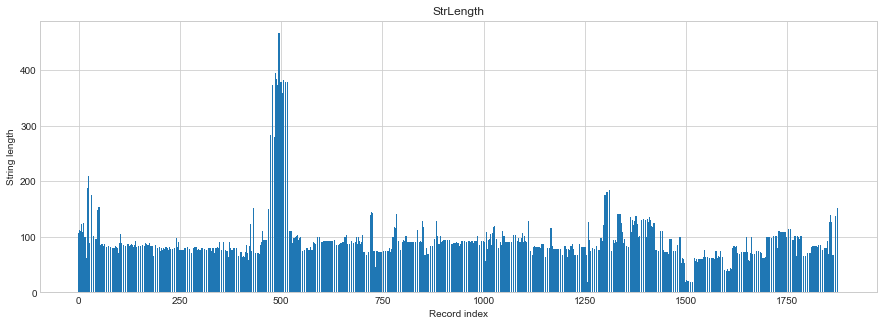

In [31]:
plt.figure(figsize=(15,5))
plt.bar(range(0,len(data_length),1),data_length)
plt.xlabel("Record index")
plt.ylabel("String length")
plt.title("StrLength")
plt.show()

## Jaccard VS Edit distance variance

In [ ]:
from sklearn.decomposition import PCA 
from numpy.linalg import svd

def PCA_SpaceVisualization(X,title='PCA plot'):
    '''
    PCA to given array X and creating a plot
    Returns PCA components array after fit_transform
    '''
    
    # PCA code
    pca = PCA(n_components=2)
    pca.fit(X)
    pcaComponents = pca.fit_transform(X) # pcaComponents is the data that I'll use from PCA
    
    # Seperating components
    first_component = [x[0] for x in pcaComponents]
    second_component = [x[1] for x in pcaComponents]
    
    # Plotting code
    fig, ax = plt.subplots(figsize=(25,10))
    ax.scatter(first_component, second_component,alpha=0) 
    fig.suptitle(title,fontsize=40,fontweight='bold')
    ax.set_xlabel('X Component',fontsize=30,fontweight='bold')
    ax.set_ylabel('Y Component',fontsize=30,fontweight='bold')
    
    for x0, y0, i in zip(first_component, second_component,range(0,len(first_component),1)):
        plt.text(x0,y0,i, ha="center", va="center",fontsize=20,color='b')
        
    return pcaComponents


In [ ]:
sent = 'This is an example of bigramms and trigramms!'
print(set(nltk.ngrams(sent, n=3)))
print(set(nltk.ngrams(nltk.word_tokenize(sent), n=3)))
print(nltk.jaccard_distance(set(nltk.ngrams(sent, n=3)),set(nltk.ngrams(sent, n=3))))
print(nltk.jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(sent), n=3)),set(nltk.ngrams(nltk.word_tokenize(sent), n=3))))

### Evaluation

In [ ]:
def similarityProbsHeatMap(similarityProb_matrix,clusters,title):
    fif,ax = plt.subplots(1,figsize=(20,20))
    colors = ['red','green','blue','yellow','orange']
    c=0
    for cl in clusters:
        for i  in range(0,len(cl)):
            for j in range(i+1,len(cl)):
                ax.add_patch(Rectangle((cl[j],cl[i]), 1, 1, fill=False, edgecolor=colors[c], lw=3))
        c+=1
#     corr = np.corrcoef(ed_matrix)
#     mask = np.zeros_like(corr)
#     mask[np.tril_indices_from(mask)] = True
    ax.set_title(title,fontsize=20,fontweight='bold')
    ax = sns.heatmap(similarityProb_matrix, linewidth=0.5,annot=True,cmap="Blues",fmt='.3g',ax=ax)
    plt.show()

In [77]:
s1 = "m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r.   andersson  nan j appl. phys."
s2 = "m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  j appl. phys. "

jc3 = jaccard_distance(set(nltk.ngrams(s1, n=3)),set(nltk.ngrams(s2, n=3)))
js3 = jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(s1), n=3)),set(nltk.ngrams(nltk.word_tokenize(s2), n=3)))
jc2 = jaccard_distance(set(nltk.ngrams(s1, n=2)),set(nltk.ngrams(s2, n=2)))
js2 = jaccard_distance(set(nltk.ngrams(nltk.word_tokenize(s1), n=2)),set(nltk.ngrams(nltk.word_tokenize(s2), n=2)))

print(jc3,js3,jc2,js2)
print(editdistance.eval(s1,s2))

0.0784313725490196 0.22727272727272727 0.012987012987012988 0.13636363636363635
7


In [32]:
results_dataframe = pd.DataFrame(columns=['max_numberOf_clusters','max_editDistance','similarityThreshold','windowSize','metric','similarityVectors',"distanceMetricEmbedding","distanceMetric","number_of_permutations","ngramms","jaccard_with_chars",'Accuracy','Precision','Recall','F1','Time'])

In [81]:
%%time

max_numberOf_clusters= 200
max_editDistance= 0.3
windowSize= 100
similarityThreshold= 0.7
metric='kendal'
similarityVectors='ranked'
number_of_permutations = 30
distanceMetric= 'jaccard'
distanceMetricEmbedding = 'euclid_jaccard'
ngramms= 3
jaccard_withchars = False

start = time.time()
model = RankedWTAHash(max_numberOf_clusters= max_numberOf_clusters,    max_editDistance= max_editDistance,    windowSize= windowSize,    similarityThreshold= similarityThreshold,    metric=metric,    similarityVectors=similarityVectors,    number_of_permutations = number_of_permutations,
distanceMetric= distanceMetric,    distanceMetricEmbedding = distanceMetricEmbedding,    ngramms= ngramms,jaccard_withchars = jaccard_withchars)
model = model.fit(data)
acc,f1,precision,recall = evaluate_cora(model.mapping_matrix,true_matrix, False)
exec_time = time.time() - start
results_dataframe.loc[len(results_dataframe)+1] = [max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations,ngramms,jaccard_withchars,acc,precision,recall,f1,exec_time]


#####################################################################
#     .~ RankedWTAHash with Vantage embeddings starts training ~.   #
#####################################################################

###########################################################
# > 1. Prototype selection phase                          #
###########################################################


-> Finding prototypes and representatives of each cluster:


-> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r.   andersson  nan j appl. phys. 
--> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  j appl. phys. 
0.7727272727272727
-> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o.  inganas and m.r.  andersson  nan j appl. phys. 
--> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r.   andersson  nan j appl. phys. 
1.0
-> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
--> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o.  inganas and m.r.  andersson  nan j appl. phys. 
1.0
-> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o.  inganas and m.r. andersson  nan j appl. phys. 
--> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
1.0
-> m. ahlskog  j. paloheimo  h. stubb  p. dyrekl

-> fahlman  s. e.  & lebiere  c. the cascade-correlation architecture. nan
--> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan journal of applied physics 
0.0
-> fahlman  s. e.  & lebiere  c. the cascade-correlation architecture. nan
--> c. ray asfahl. robots and manufacturing automation. nan
0.0
-> fahlman  s. e.  & lebiere  c. the cascade correlation architecture. nan
--> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan journal of applied physics 
0.0
-> fahlman  s. e.  & lebiere  c. the cascade correlation architecture. nan
--> c. ray asfahl. robots and manufacturing automation. nan
0.0
-> fahlman  s. e.  & lebiere  c. the cascade correlation architecture. nan
--> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan journal of applied physics 
0.0
-> fahlman  s. e.  & lebiere  c. the cascade correlation architecture. nan
--> c. ray asfahl. robots 

0.0
-> common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  daniel l. weinreb  daniel g. bobrow  linda g. demichiel  sonya e. keene  gregor kiczales  crispin perdue  kent m. pitman  richard c. waters  and jon l white. nan nan
--> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan journal of applied physics 
0.0
-> common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  daniel l. weinreb  daniel g. bobrow  linda g. demichiel  sonya e. keene  gregor kiczales  crispin perdue  kent m. pitman  richard c. waters  and jon l white. nan nan
--> c. ray asfahl. robots and manufacturing automation. nan
0.0
-> common lisp: the language (second edition). by guy l. steele jr.  scott e. fahlman  richard p. gabriel  david a. moon  daniel l. weinreb  daniel g. bobrow  linda g. demichiel  sonya e. keene  gregor kiczales  crispin perd

0.0
-> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
--> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan journal of applied physics 
0.0
-> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
--> c. ray asfahl. robots and manufacturing automation. nan
0.0
-> aha  d.w.  kibler  d.  and albert  m.k. instance-based learning algorithms. machine learning 
--> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan journal of applied physics 
0.0
-> aha  d.w.  kibler  d.  and albert  m.k. instance-based learning algorithms. machine learning 
--> c. ray asfahl. robots and manufacturing automation. nan
0.0
-> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
--> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan journal of applied physics 
0.0
-> d.

0.0
-> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
--> c. ray asfahl. robots and manufacturing automation. nan
0.0
-> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
--> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan journal of applied physics 
0.0
-> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
--> c. ray asfahl. robots and manufacturing automation. nan
0.0
-> d.w. aha  d. kibler  and m.k. albert. instance-based learning algorithms. machine learning 
--> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan journal of applied physics 
0.0
-> d.w. aha  d. kibler  and m.k. albert. instance-based learning algorithms. machine learning 
--> c. ray asfahl. robots and manufacturing automation. nan
0.0
-> d. w. aha  d. kibler  and m. k. albert. instance-based learning algorithms

-> pazzani  m. & kibler  d. the utility of knowledge in inductive learning. machine learning 
--> c. ray asfahl. robots and manufacturing automation. nan
0.0
-> pazzani  m. & kibler  d. the utility of knowledge in inductive learning. machine learning 
--> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan journal of applied physics 
0.0
-> pazzani  m. & kibler  d. the utility of knowledge in inductive learning. machine learning 
--> c. ray asfahl. robots and manufacturing automation. nan
0.0
-> pazzani  m. & kibler  d. the utility of knowledge in inductive learning. machine learning 
--> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan journal of applied physics 
0.0
-> pazzani  m. & kibler  d. the utility of knowledge in inductive learning. machine learning 
--> c. ray asfahl. robots and manufacturing automation. nan
0.0
-> pazzani  m. & kibler  d. the utility of knowledge in inductive learning

--> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan journal of applied physics 
0.0
-> b. a. draper  carla e. brodley  and paul e. utgoff. goal-directed classification using linear machine decision trees. ieee transactions on pattern analysis and machine intelligence 
--> c. ray asfahl. robots and manufacturing automation. nan
0.0
-> b. a. draper  carla e. brodley  and paul e. utgoff. goal-directed classification using linear machine decision trees. ieee transactions on pattern analysis and machine intelligence 
--> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan journal of applied physics 
0.0
-> b. a. draper  carla e. brodley  and paul e. utgoff. goal-directed classification using linear machine decision trees. ieee transactions on pattern analysis and machine intelligence 
--> c. ray asfahl. robots and manufacturing automation. nan
0.0
-> b. a. draper  carla e. brodley  and paul e. utgoff

0.0
-> utgoff  p. e. shift of bias for inductive concept learning. nan
--> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan journal of applied physics 
0.0
-> utgoff  p. e. shift of bias for inductive concept learning. nan
--> c. ray asfahl. robots and manufacturing automation. nan
0.0
-> utgoff  p. e. shift of bias for inductive concept learning. nan
--> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan journal of applied physics 
0.0
-> utgoff  p. e. shift of bias for inductive concept learning. nan
--> c. ray asfahl. robots and manufacturing automation. nan
0.0
-> utgoff  p. e. shift of bias for inductive concept learning. nan
--> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan journal of applied physics 
0.0
-> utgoff  p. e. shift of bias for inductive concept learning. nan
--> c. ray asfahl. robots and manufacturing automation. nan
0.0
-> utg

0.0
-> utgoff  p. e. perceptron trees: a case study in hybrid concept representations. connection science 
--> c. ray asfahl. robots and manufacturing automation. nan
0.0
-> utgoff  p. e. perceptron trees: a case study in hybrid concept representations. connection science 
--> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan journal of applied physics 
0.0
-> utgoff  p. e. perceptron trees: a case study in hybrid concept representations. connection science 
--> c. ray asfahl. robots and manufacturing automation. nan
0.0
-> utgoff  p. e. perceptron trees: a case study in hybrid concept representations. connection science 
--> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan journal of applied physics 
0.0
-> utgoff  p. e. perceptron trees: a case study in hybrid concept representations. connection science 
--> c. ray asfahl. robots and manufacturing automation. nan
0.0
-> utgoff  p. e. perceptr

-> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  j appl. phys. 
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
1.0
-> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r.   andersson  nan j appl. phys. 
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o.  inganas and m.r.  andersson  nan j appl. phys. 
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> m. ahlskog  j. paloheimo  h. stubb  p. dyreklev  m. fahlman  o. inganas and m.r. andersson  nan j appl. phys. 
--> d. aha  d. kibler  and m. albert. instance-based learning algorit

0.0
-> fahlman  s.e. and lebiere  c. the cascade-correlation learning architecture  nan
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> s.e. fahlman and c. lebiere  "the cascade-correlation learning architecture " nan
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> fahlman  s. e. and lebiere  c. the cascade-correlation learning architecture. nan
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> fahlmann  scott  c. lebiere. the cascade-correlation learning architechture. nan
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> fahlmann  scott  c. lebiere. the cascade-correlation learning architecture. nan
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> s. e. fahlman and c. lebiere the cascade-correlation learning architecture  nan
--> d. aha  

1.0
-> aha  d. w.  kibler  d.  albert  m. k. "instance-based learning methods " machine learning 
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> aha  d. w.  kibler  d.  albert  m. k. "instance-based learning methods " machine learning 
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> aha  d. w.  kibler  d.  albert  m. k. "instance-based learning methods " machine learning 
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> aha  d.  d. kibler  albert & m. instance-based learning algorithms. machine learning
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.21052631578947367
-> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
1.0
-> d. aha  d. kibler  and m. albert  "i

-> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
1.0
-> d.w. aha  d. kibler  and m.k. albert. instance-based learning algorithms. machine learning 
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.47058823529411764
-> d. w. aha  d. kibler  and m. k. albert. instance-based learning algorithms. machine learning 
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.5294117647058824
-> david w. aha  dennis kibler  and mark k. albert. instance-based learning algorithms. machine learning 
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.30000000000000004
-> david w. aha  dennis kibler  and mark k. albert. instance-based learning algorithms. machine learning 
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. 

--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> m. connell and p. utgoff. learning to control a dynamic physical system  nan
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> m. connell and p. utgoff. learning to control a dynamic physical system  nan
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> craven  m. w. & shavlik  j. w. learning symbolic rules using artificial neural networks  nan
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> craven  m. w. & shavlik  j. w. learning symbolic rules using artificial neural networks  nan
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> mark w. craven and jude w. shavlik. learning symbolic rules using artificial neural networks. nan
--> d. aha  d. kibler  and m. albert. instance-based learning algor

--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> utgoff  p. e. shift of bias of inductive concept learning. nan
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> utgoff  p. e. shift of bias of inductive concept learning. nan
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> utgoff  p. e. shift of bias of inductive concept learning. nan
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> utgoff  p. e. shift of bias of inductive concept learning. nan
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> p. e. utgoff. shift of bias for inductive concept learning. nan
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> p. utgoff  shift of bias for inductive concept learning  nan
--> d. aha  d. kibler  and m.

-> p.e. utgoff  shift of bias of inductive concept learning. in r.s. nan
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> paul e. utgoff. feature function learning for value approximation. nan
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.0
-> utgoff  p. e.  berkman  n. c.  & clouse  j. a. decision tree induction based on efficient tree restructuring. machine learning.
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.032258064516129004
-> utgoff  p. e.; berkman  n. c.; and clouse  j. a. decision tree induction based on efficient tree restructuring. machine learning
--> d. aha  d. kibler  and m. albert. instance-based learning algorithms. machine learning 
0.03125
-> paul e. utgoff  neil c. berkman  and jeffery a. clouse. decision tree induction based on efficient tree restructuring. machine learning  nan
--> d. aha  d. kibler  and m. albert. ins

C:\Users\nikol\anaconda3\lib\site-packages\ipykernel_launcher.py:492: UserWarning: Window size greater than vector dimension


- WTA buckets: 
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]  ->  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 2

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

C:\Users\nikol\anaconda3\lib\site-packages\ipykernel_launcher.py:420: UserWarning: Vector dim equal to 1-Setting metric to kendalltau


KeyboardInterrupt: 

In [ ]:
%%time
model = RankedWTAHash(
    max_numberOf_clusters= 30,
    max_editDistance= 0.6,
    windowSize= 5,
    similarityThreshold= 0.799,
    metric='kendal',
    similarityVectors='ranked',
    number_of_permutations = 5,
    distanceMetric= 'jaccard',
    distanceMetricEmbedding = 'l_inf',
    ngramms= 3,
    jaccard_withchars = False
)
model = model.fit(data)
evaluate_cora(model.mapping_matrix,true_matrix, False)
print(np.array(model.similarityProb_matrix)

## Performance details

### Embeddings

In [ ]:
pcaComponents = PCA_SpaceVisualization(model.Embeddings)

In [ ]:
pcaComponents = PCA_SpaceVisualization(model.rankedVectors)

### Grid Search

In [ ]:
max_numberOf_clusters= [5,10,20]
max_editDistance= [50,100,200,300]
windowSize= [3, 5, 10, 15]
similarityThreshold= [0.6,0.7,0.8]
metric= ['kendal', 'customKendal','jaccard','pearson']
similarityVectors= ['ranked','initial']
distanceMetric= ['edit']
distanceMetricEmbedding = ['edit','euclidean']
number_of_permutations = [1,3,5,7]


# results = GridSearch_cora(data,true_matrix,max_numberOf_clusters,max_editDistance,similarityThreshold,windowSize,metric,similarityVectors,distanceMetricEmbedding,distanceMetric,number_of_permutations)

In [ ]:
# results.sort_values(by=['Accuracy'],ascending=False)

---

# References

1.   [The dissimilarity representation for pattern recognition, a tutorial
Robert P.W. Duin and Elzbieta Pekalska Delft University of Technology, The Netherlands School of Computer Science, University of Manchester, United Kingdom](http://homepage.tudelft.nl/a9p19/presentations/DisRep_Tutorial_doc.pdf)